# Time Series Classification

In [1]:
import multipers as mp
from os.path import expanduser
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from gudhi.point_cloud.timedelay import TimeDelayEmbedding
import numpy as np
import matplotlib.pyplot as plt

This dataset can be found at https://www.timeseriesclassification.com/description.php?Dataset=Coffee

In [2]:
DATASET_PATH=expanduser("~/Datasets/UCR/")
dataset_path = DATASET_PATH + "Coffee/Coffee"
xtrain = np.array(pd.read_csv(dataset_path+"_TRAIN.tsv", delimiter='\t', header=None, index_col=None))
ytrain = LabelEncoder().fit_transform(xtrain[:,0])
xtrain = xtrain[:,1:]
xtest = np.array(pd.read_csv(dataset_path + "_TEST.tsv", delimiter='\t', header=None, index_col=None))
ytest = LabelEncoder().fit_transform(xtest[:,0])
xtest = xtest[:,1:]

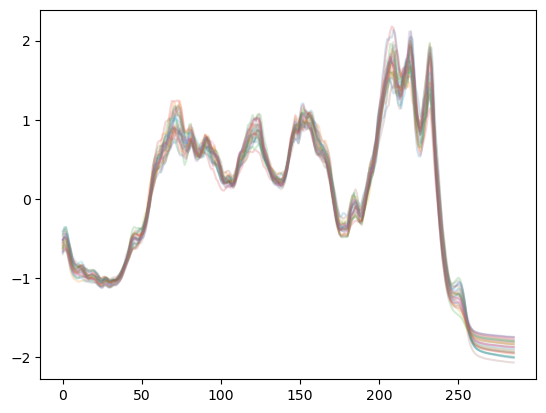

In [3]:
## the time-series of the Coffee dataset
plt.plot(xtrain.T, alpha=.2);

## Time Delay Embedding

In this format, time series are not very well suited for a topological analysis.

However, using Time Delay Embedding, which falls into the theory of 
[Taken's Theorem](https://en.wikipedia.org/wiki/Takens%27s_theorem)
we embed time series into a euclidian space, turning them into curves in a euclidian space.
<br>
The advantages of this approach is that this embedding doesn't depend on reparametrization of the time series,
and its construction doesn't depend on the number of sampling points.

Furthermore, if the parameters of this embedding are well chosen, the periodicity properties of the 
time series translates into topological properties of the embedding.

Using the usual Rips-Density bifiltration allows to recover the topological properties (and thus some Fourier coefficients informations)
from the time series, as well as their importance (via the density parameter).

Of course, a bunch of reasonable (and faster) multi-filtration can be used instead of this one, e.g., Function-Delaunay.

In [4]:
## Default parameters
dim=3
delay=1
skip=1
TDE = TimeDelayEmbedding(dim=dim, delay=delay, skip=skip)
xtrain = TDE.transform(xtrain)
xtest = TDE.transform(xtest)

In [5]:
np.asarray(xtrain).shape # num_time_series, embedding_curve_sampling, embedding_dimension

(28, 284, 3)

## Step by step

This is a point cloud now, so it can be dealt with with usual pipelines. 
<br>
Here each of entry of `xtrain` will be turned into two multi-simplextrees : 
 - Rips + (gaussian kernel density estimation with bandwith $0.1*\mathrm{scale}(\mathrm{xtrain})$)
 - Rips + (Distance to measure with mass threshold 0.1)

And we'll see which one gives the best results later.

In [6]:
import multipers.ml.point_clouds as mmp
sts = mmp.PointCloud2SimplexTree(bandwidths=[-.1], masses=[.1], num_collapses=-2, complex="rips", expand_dim=2, sparse=.5).fit_transform(xtrain)
sts[0]

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode
[KeOps] Generating code for formula Sum_Reduction(Exp(-Sum(((Var(0,3,0)-Var(1,3,1))/Var(2,1,2))**2)/2)/Var(3,1,2),1) ... OK
[pyKeOps] Compiling pykeops cpp cd1a4ec590 module ... OK


We generate a module approximation for each simplextree

In [7]:
import multipers.ml.mma as mma
mods = mma.SimplexTree2MMA().fit_transform(sts)

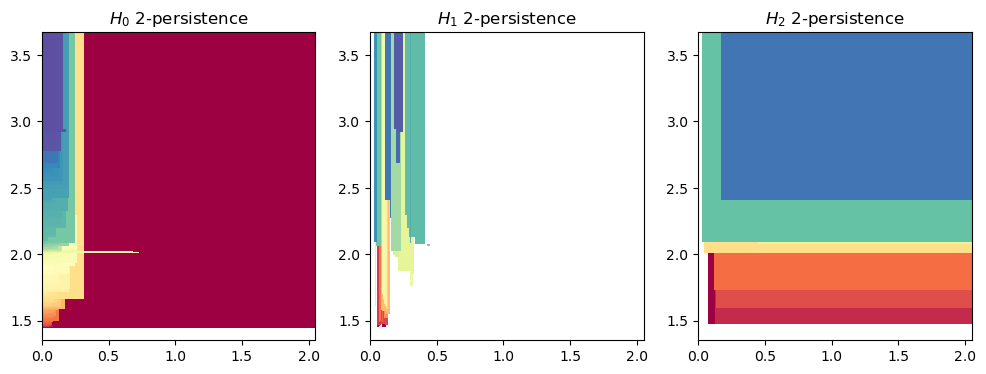

In [8]:
mods[0][0].plot()

Normalize the filtration values

In [9]:
mods = mma.MMAFormatter(normalize=True).fit_transform(mods)

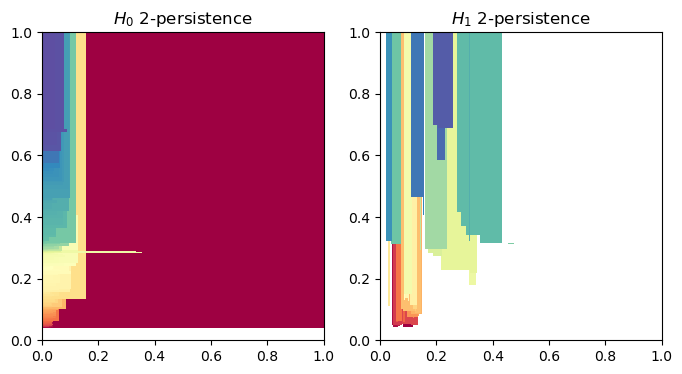

In [10]:
mod = mods[0][0]
mod.plot()

We can then turn these into a vector with :cite:p:`mma_vect`.

In [11]:
imgs = mma.MMA2IMG(bandwidth=.01, degrees = [0,1], n_jobs = 1, resolution=50, kernel = "gaussian", flatten=False).fit_transform(mods)

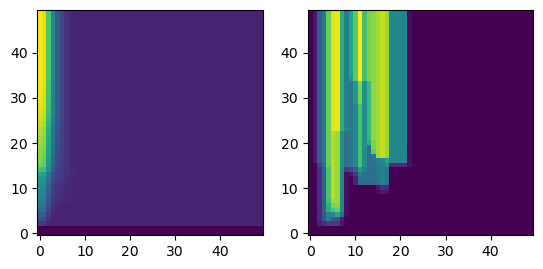

In [12]:
img0, img1 = imgs[0][0]
fig, axs = plt.subplots(ncols=2)

axs[0].imshow(img0, origin="lower")
axs[1].imshow(img1, origin="lower")

And classify all of this using, e.g., a Random Forest Classifier. 

## Full pipeline

**Note.** Although normalization allow for reasonable parameter selection without prior knowledge, 
it is **very** recommended to cross-validate the parameters using, e.g., scikit-learn's GridSearchCV,
to significantly increase the performances.

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

In [14]:
## We wrap up everything into this pipeline
pipeline = Pipeline([
    ("st", mmp.PointCloud2SimplexTree(bandwidths=[-.1], masses=[.1], num_collapses=-2, complex="rips", expand_dim=2)),
    ("mod", mma.SimplexTree2MMA(n_jobs=-1)),
    ("normalization", mma.MMAFormatter(normalize=True)),
    ("vectorization", mma.MMA2IMG(bandwidth=.1, degrees = [0,1], n_jobs = -1, resolution=50, kernel = "gaussian", flatten=True)),
    ("classifier", RandomForestClassifier()),
])

In [15]:
# Train step
pipeline.fit(xtrain,ytrain)

Pipeline(steps=[('st',
                 PointCloud2SimplexTree(bandwidths=[-0.1], expand_dim=2,
                                        masses=[0.1], num_collapses=-2)),
                ('mod', SimplexTree2MMA(n_jobs=-1)),
                ('normalization', MMAFormatter(axis=-1, normalize=True)),
                ('vectorization',
                 MMA2IMG(degrees=[0, 1], flatten=True, kernel='gaussian')),
                ('classifier', RandomForestClassifier())])

In [16]:
# Test score
pipeline.score(xtest,ytest)

1.0